In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## Tensors and variables in TensorFlow

In [2]:
# Constant tensors
tf.ones(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[1.],
       [1.]], dtype=float32)>

In [3]:
tf.zeros(shape=(2, 1))

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[0.],
       [0.]], dtype=float32)>

In [4]:
tf.constant([1, 2, 3], dtype="float32")

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [5]:
# Random Tensors
x = tf.random.normal(shape=(2, 2), mean=0.0, stddev=1.0)
print(x)

tf.Tensor(
[[1.2722864  0.49293077]
 [0.26790026 0.6254077 ]], shape=(2, 2), dtype=float32)


In [7]:
x = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)
print(x)

tf.Tensor(
[[0.4013425 ]
 [0.35529828]
 [0.7478473 ]], shape=(3, 1), dtype=float32)


In [8]:
# Tensor assignment and the Variable class

# TensorFlow tensors are not assignable, they are constant
x = tf.ones(shape=(2, 2))
x[0, 0] = 0.0

TypeError: 'tensorflow.python.framework.ops.EagerTensor' object does not support item assignment

In [9]:
# but we can assign it via tf.Variable
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

<tf.Variable 'Variable:0' shape=(3, 1) dtype=float32, numpy=
array([[-1.0099435],
       [ 0.7465027],
       [-1.2525133]], dtype=float32)>


In [10]:
v.assign(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[1.],
       [1.],
       [1.]], dtype=float32)>

In [11]:
v[0, 0].assign(3.)

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[3.],
       [1.],
       [1.]], dtype=float32)>

In [12]:
v.assign_add(tf.ones((3, 1)))

<tf.Variable 'UnreadVariable' shape=(3, 1) dtype=float32, numpy=
array([[4.],
       [2.],
       [2.]], dtype=float32)>

In [13]:
# Tensor operations: Doing math in TensorFlow
a = tf.ones((2, 2))
b = tf.square(a)
c = tf.sqrt(a)
d = b + c
e = tf.matmul(a, b)
f = tf.concat((a, b), axis=0)


In [14]:
def dense(inputs, W, b):
  return tf.nn.relu(tf.matmul(inputs, W) + b)

In [15]:
# Gradients in TensorFlow: A second look at the GradientTape API

input_var = tf.Variable(initial_value=3.0)
with tf.GradientTape() as tape:
  result = tf.square(input_var)
gradient = tape.gradient(result, input_var)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [16]:
input_const = tf.constant(3.0)
with tf.GradientTape() as tape:
  tape.watch(input_const)
  result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

tf.Tensor(6.0, shape=(), dtype=float32)


In [17]:
# Using nested gradient tapes to compute second-order gradients

time = tf.Variable(0.0)
with tf.GradientTape() as outer_tape:
  with tf.GradientTape() as inner_tape:
    position = 4.9 * time ** 2
  speed = inner_tape.gradient(position, time)
acceleration = outer_tape.gradient(speed, time)
print(acceleration)

tf.Tensor(9.8, shape=(), dtype=float32)


In [19]:
# Making TensorFlow functions fast using compilation

# keep in mind that there is a drawback: debugging is heavily difficult
# comparing to executing "eagerly"

# graph mode compilation
@tf.function
def dense(inputs, W, b):
  return tf.nn.relu(tf.matmul(inputs, W) + b)

In [20]:
# XLA mode compilation
@tf.function(jit_compile=True)
def dense(inputs, W, b):
  return tf.nn.relu(tf.matmul(inputs, W) + b)

## An end-to-end example: A linear classifier in pure TensorFlow

In [24]:
#  Generating two classes of random points in a 2D plane
num_samples_per_class = 1000

negative_samples = np.random.multivariate_normal(
    mean=[0, 3], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0], cov=[[1, 0.5], [0.5, 1]], size=num_samples_per_class
)

In [25]:
# Stacking the two classes into an array with shape (2000, 2)
inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)

In [26]:
# Generating the corresponding targets (0 and 1)
targets = np.vstack(
    (
        np.zeros((num_samples_per_class, 1), dtype="float32"),
        np.ones((num_samples_per_class, 1), dtype="float32"),
    )
)

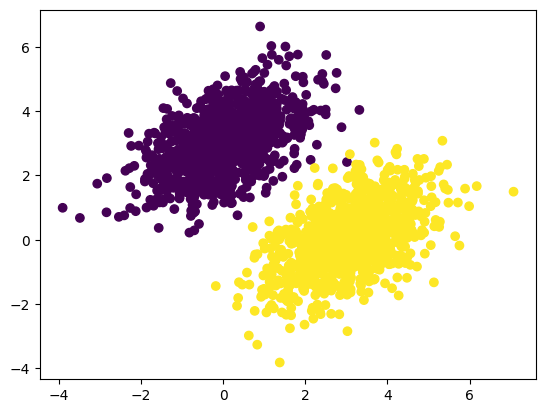

In [28]:
# Plotting the two point classes
plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0])
plt.show()

In [29]:
# Creating the linear classifier variables
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim,)))

In [30]:
# The forward pass function
def model(inputs, W, b):
  return tf.matmul(inputs, W) + b

In [31]:
# The mean squared error loss function
def mean_squared_error(targets, predictions):
  per_sample_losses = tf.square(targets - predictions)
  return tf.reduce_mean(per_sample_losses)

In [32]:
# The training-step function
learning_rate = 0.1

@tf.function(jit_compile=True)
def training_step(inputs, targets, W, b):
  with tf.GradientTape() as tape:
    predictions = model(inputs, W, b)
    loss = mean_squared_error(targets, predictions)
  grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
  W.assign_sub(grad_loss_wrt_W * learning_rate)
  b.assign_sub(grad_loss_wrt_b * learning_rate)
  return loss

In [33]:
# The Batch training loop
for step in range(40):
  loss = training_step(inputs, targets, W, b)
  print(f"Loss at step {step}: {loss:.4f}")

Loss at step 0: 2.1173
Loss at step 1: 0.3913
Loss at step 2: 0.1559
Loss at step 3: 0.1137
Loss at step 4: 0.1014
Loss at step 5: 0.0942
Loss at step 6: 0.0882
Loss at step 7: 0.0828
Loss at step 8: 0.0778
Loss at step 9: 0.0733
Loss at step 10: 0.0692
Loss at step 11: 0.0654
Loss at step 12: 0.0619
Loss at step 13: 0.0587
Loss at step 14: 0.0558
Loss at step 15: 0.0531
Loss at step 16: 0.0507
Loss at step 17: 0.0485
Loss at step 18: 0.0464
Loss at step 19: 0.0445
Loss at step 20: 0.0428
Loss at step 21: 0.0413
Loss at step 22: 0.0398
Loss at step 23: 0.0385
Loss at step 24: 0.0373
Loss at step 25: 0.0362
Loss at step 26: 0.0352
Loss at step 27: 0.0343
Loss at step 28: 0.0334
Loss at step 29: 0.0326
Loss at step 30: 0.0319
Loss at step 31: 0.0313
Loss at step 32: 0.0307
Loss at step 33: 0.0301
Loss at step 34: 0.0296
Loss at step 35: 0.0292
Loss at step 36: 0.0288
Loss at step 37: 0.0284
Loss at step 38: 0.0280
Loss at step 39: 0.0277


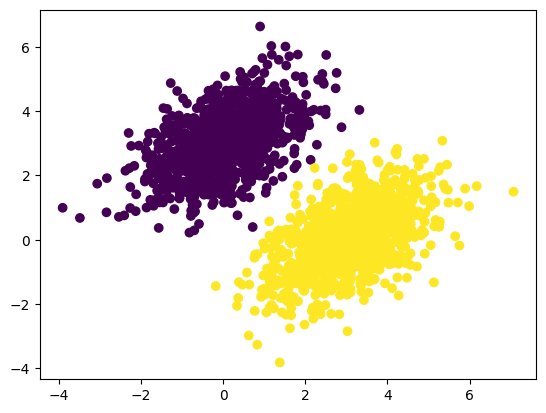

In [34]:
predictions = model(inputs, W, b)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)
plt.show()

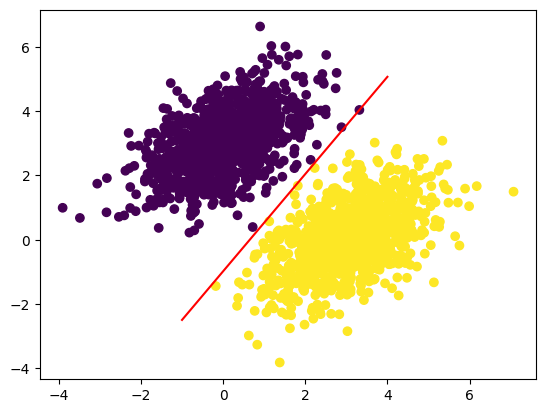

In [35]:
x = np.linspace(-1, 4, 100)
y = -W[0] / W[1] * x + (0.5 - b) / W[1]
plt.plot(x, y, "-r")
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5)